In [4]:
import os
from zipfile import ZipFile
from kaggle.api.kaggle_api_extended import KaggleApi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [5]:
dataset_path = "./17flowers_dataset"

os.makedirs(dataset_path, exist_ok=True)

api = KaggleApi()
api.authenticate()

In [6]:
print("Downloading dataset...")
api.dataset_download_files('aima138/17flowerclasses', path=dataset_path, unzip=True)
print("Dataset downloaded and extracted to:", dataset_path)

Dataset URL: https://www.kaggle.com/datasets/aima138/17flowerclasses
Dataset downloaded and extracted to: ./17flowers_dataset


In [7]:
dataset_dir = dataset_path 
train_dir = os.path.join(dataset_dir,"17flowerclasses", "train")
test_dir  = os.path.join(dataset_dir,"17flowerclasses" ,"test") 

In [ ]:
IMG_SIZE = (160, 160)   
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_EPOCHS_HEAD = 20
NUM_EPOCHS_FINETUNE = 20
PATIENCE = 5
MODEL_SAVE_PATH = "flower17_model.keras"

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 1190 files belonging to 17 classes.
Found 170 files belonging to 17 classes.
Classes: ['Bluebell', 'ButterCup', 'ColtsFoot', 'Cowslip', 'Crocus', 'Daffodil', 'Daisy', 'Dandelion', 'Fritillary', 'Iris', 'LilyValley', 'Pansy', 'Snowdrop', 'Sunflower', 'Tigerlily', 'WindFlower', 'tulip']


In [10]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
])

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (tf.image.resize(x, IMG_SIZE), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(1000)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds, training=False)

In [11]:
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

In [12]:
inputs = keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)           
x = preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 5, 5, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 17)                21777 

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, monitor="val_accuracy", save_best_only=True, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=PATIENCE, restore_best_weights=True)
]


In [15]:
history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS_HEAD,
    callbacks=callbacks
)

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 1.4506 - accuracy: 0.5513
Epoch 1: val_accuracy improved from -inf to 0.74706, saving model to flower17_model.h5


C:\Users\M_Mashayekhi\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 163s 3s/step - loss: 1.4506 - accuracy: 0.5513 - val_loss: 0.8470 - val_accuracy: 0.7471
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.5410 - accuracy: 0.8353
Epoch 2: val_accuracy improved from 0.74706 to 0.81765, saving model to flower17_model.h5
38/38 [==============================] - 119s 3s/step - loss: 0.5410 - accuracy: 0.8353 - val_loss: 0.6011 - val_accuracy: 0.8176
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.4148 - accuracy: 0.8773
Epoch 3: val_accuracy improved from 0.81765 to 0.83529, saving model to flower17_model.h5
38/38 [==============================] - 110s 3s/step - loss: 0.4148 - accuracy: 0.8773 - val_loss: 0.6086 - val_accuracy: 0.8353
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.3811 - accuracy: 0.8882
Epoch 4: val_accuracy did not improve from 0.83529
38/38 [==============================] - 111s 3s/step - loss: 0.3811 - accuracy: 0.8882 - val_los

In [16]:
base_model.trainable = True 
   
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS_FINETUNE,
    callbacks=callbacks
)


Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9899
Epoch 1: val_accuracy did not improve from 0.92941
38/38 [==============================] - 130s 3s/step - loss: 0.0271 - accuracy: 0.9899 - val_loss: 0.1844 - val_accuracy: 0.9235
Epoch 2/20
38/38 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9966
Epoch 2: val_accuracy did not improve from 0.92941
38/38 [==============================] - 121s 3s/step - loss: 0.0208 - accuracy: 0.9966 - val_loss: 0.2090 - val_accuracy: 0.9118
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9924
Epoch 3: val_accuracy did not improve from 0.92941
38/38 [==============================] - 114s 3s/step - loss: 0.0216 - accuracy: 0.9924 - val_loss: 0.2455 - val_accuracy: 0.9118
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9958
Epoch 4: val_accuracy did not improve from 0.92941
38/38 [=======================

In [17]:
loss, acc = model.evaluate(val_ds)
print(f"Final val loss: {loss:.4f}  val acc: {acc:.4f}")
 


6/6 [==============================] - 4s 603ms/step - loss: 0.1844 - accuracy: 0.9235
Final val loss: 0.1844  val acc: 0.9235


Saved model to flower17_model.h5


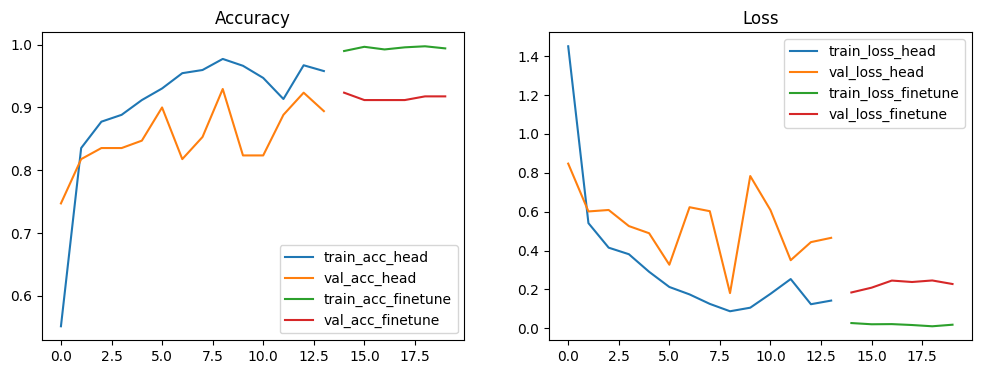

In [18]:
model.save(MODEL_SAVE_PATH)
print("Saved model to", MODEL_SAVE_PATH)
 
def plot_history(h1, h2=None):
    plt.figure(figsize=(12,4))
    # accuracy
    plt.subplot(1,2,1)
    plt.plot(h1.history['accuracy'], label='train_acc_head')
    plt.plot(h1.history['val_accuracy'], label='val_acc_head')
    if h2:
        plt.plot(range(len(h1.history['accuracy']), len(h1.history['accuracy'])+len(h2.history['accuracy'])),
                 h2.history['accuracy'], label='train_acc_finetune')
        plt.plot(range(len(h1.history['val_accuracy']), len(h1.history['val_accuracy'])+len(h2.history['val_accuracy'])),
                 h2.history['val_accuracy'], label='val_acc_finetune')
    plt.legend(); plt.title("Accuracy")
    # loss
    plt.subplot(1,2,2)
    plt.plot(h1.history['loss'], label='train_loss_head')
    plt.plot(h1.history['val_loss'], label='val_loss_head')
    if h2:
        plt.plot(range(len(h1.history['loss']), len(h1.history['loss'])+len(h2.history['loss'])),
                 h2.history['loss'], label='train_loss_finetune')
        plt.plot(range(len(h1.history['val_loss']), len(h1.history['val_loss'])+len(h2.history['val_loss'])),
                 h2.history['val_loss'], label='val_loss_finetune')
    plt.legend(); plt.title("Loss")
    plt.show()

plot_history(history_head, history_finetune)

In [19]:
 
from tensorflow.keras.preprocessing import image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

external_images = [
    "external1.jpg",
    "external2.jpg",
    "external3.jpg"
] 
plt.figure(figsize=(12,4))
for i, img_path in enumerate(external_images):
    if not Path(img_path).exists():
        print("File not found:", img_path)
        continue
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    pred_label = class_names[np.argmax(preds)]
    pred_conf  = float(np.max(preds))

    plt.subplot(1, len(external_images), i+1)
    plt.imshow((image.img_to_array(img)/255.).astype(np.float32))
    plt.title(f"{pred_label}\n{pred_conf:.2f}")
    plt.axis('off')
plt.show()

File not found: external1.jpg
File not found: external2.jpg
File not found: external3.jpg


<Figure size 1200x400 with 0 Axes>